# **Space X  Falcon 9 First Stage Landing Analysis**


# Data Collection - Web Scraping 

### Import Libraries and Define Auxiliary Functions

In [1]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    out=[i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


### Load data using Web Scraping from wiki

In [3]:
#!pip3 install beautifulsoup4
#!pip3 install requests

In [4]:
#Get web Response
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response = requests.get(static_url).text
soup = BeautifulSoup(response, 'html.parser')
print(soup.title)


<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [5]:
#Retrive Actual records, which is the 3rd table in the page

html_tables = soup.find_all("table")
first_launch_table = html_tables[2]


In [6]:
#Get the column name one by one from the table

temp = soup.find_all('th')
column_names = []
temp = first_launch_table.find_all('th')

for i in temp:
    colname = extract_column_from_header(i)
    if (colname != None and len(colname) > 0):
        column_names.append(colname)        
        
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


### Load dataframe


In [7]:
launch_dict= dict.fromkeys(column_names)
del launch_dict['Date and time ( )']

launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [8]:
extracted_row = 0
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
            
        #get table element and save as dictionary
        row=rows.find_all('td')
        if flag:
            extracted_row += 1
            
            launch_dict['Flight No.'].append(flight_number) 
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            #print(date)
            
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            #print(time)
              
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string            
            launch_dict['Version Booster'].append(bv)
           # print(bv)
          
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            #print(launch_site)
         
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            #print(payload)
            
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            #print(payload)
            
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
           # print(orbit)
            
            customer = row[6].text.strip()
            launch_dict['Customer'].append(customer)
            #print(customer)
            
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            #print(launch_outcome)
            
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
           # print(booster_landing)
            

In [9]:
#Create dataframe 

df=pd.DataFrame.from_dict(launch_dict)
df = df.drop(df.index[88])
df.reset_index(drop=True, inplace=True)
df

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA (COTS)\nNRO,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA (COTS),Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA (CRS),Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA (CRS),Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
115,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1051.10,Success,9 May 2021,06:42
116,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX Capella Space and Tyvak,Success\n,F9 B5B1058.8,Success,15 May 2021,22:56
117,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1063.2,Success,26 May 2021,18:59
118,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA (CRS),Success\n,F9 B5B1067.1,Success,3 June 2021,17:29


# Data Wrangling

### Deal with missing/Empty values and Special characters

In [10]:
#check if any missing values
temp = df.isnull().sum()
tempCount = 0
for i in range(len(temp)):
    if (temp[i]==0):
        tempCount=tempCount+1

if (tempCount==len(temp)):
    print("No Missing Values for all columns")

list(df.columns)

No Missing Values for all columns


['Flight No.',
 'Launch site',
 'Payload',
 'Payload mass',
 'Orbit',
 'Customer',
 'Launch outcome',
 'Version Booster',
 'Booster landing',
 'Date',
 'Time']

In [11]:
# Replace PayloadMass of 0 value with with its median value

df_payloadmass = df['Payload mass']
df_payloadmass = ((df_payloadmass.str.replace("kg","")).str.replace(",","")).str.replace("~","")
df_payloadmass = df_payloadmass.str.replace(" ","")
df_payloadmass = df_payloadmass.str.replace("C","0")

df_payloadmass.replace(np.nan, 0, inplace=True)
df_payloadmass = df_payloadmass.astype(int)
payloadmass_med = df_payloadmass.median()
df_payloadmass.replace(0, int(payloadmass_med), inplace=True)    

df['Payload mass'] = df_payloadmass

In [12]:
df['Launch site'] = df['Launch site'].str.replace("\n","")
df['Customer'] = df['Customer'].str.replace("\n","")
df['Launch outcome'] = df['Launch outcome'].str.replace("\n","")
df['Booster landing'] = df['Booster landing'].str.replace("\n","")
df['Booster landing'] = df['Booster landing'].str.replace(" ","")

## Exploratory Data Analysis ¶


In [13]:
df2 = df.copy()
df2.dtypes

Flight No.         object
Launch site        object
Payload            object
Payload mass        int32
Orbit              object
Customer           object
Launch outcome     object
Version Booster    object
Booster landing    object
Date               object
Time               object
dtype: object

### EDA: Query Pandas DataFrame with SQL


In [14]:
#!pip install -U pandasql

In [15]:
from pandasql import sqldf
from sklearn import datasets

In [16]:
q = "SELECT * FROM df2"
sqldf(q, globals())


,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,4933,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,4933,LEO,NASA (COTS)NRO,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525,LEO,NASA (COTS),Success,F9 v1.0B0005.1,Noattempt,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,4700,LEO,NASA (CRS),Success,F9 v1.0B0006.1,Noattempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,4877,LEO,NASA (CRS),Success,F9 v1.0B0007.1,Noattempt,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
115,117,CCSFS,Starlink,15600,LEO,SpaceX,Success,F9 B5B1051.10,Success,9 May 2021,06:42
116,118,KSC,Starlink,14000,LEO,SpaceX Capella Space and Tyvak,Success,F9 B5B1058.8,Success,15 May 2021,22:56
117,119,CCSFS,Starlink,15600,LEO,SpaceX,Success,F9 B5B1063.2,Success,26 May 2021,18:59
118,120,KSC,SpaceX CRS-22,3328,LEO,NASA (CRS),Success,F9 B5B1067.1,Success,3 June 2021,17:29


In [17]:
#number of launchsite
q = 'SELECT count("Launch site") as count, "Launch site" FROM df2 group by "Launch site"'
sqldf(q, globals())

,count,Launch site
0,39,CCAFS
1,12,CCSFS
2,20,Cape Canaveral
3,33,KSC
4,16,VAFB


In [18]:
# types of landing
q = 'SELECT distinct("Booster landing") FROM df2'
sqldf(q, globals())


,Booster landing
0,Failure
1,Noattempt
2,Uncontrolled
3,Controlled
4,Precluded
5,Success


In [19]:
# count of each landing
q = 'SELECT count("Booster landing") as count, "Booster landing" FROM df2 group by "Booster landing"'
sqldf(q, globals())

,count,Booster landing
0,5,Controlled
1,11,Failure
2,22,Noattempt
3,1,Precluded
4,79,Success
5,2,Uncontrolled


In [20]:
q = 'SELECT avg("Payload mass") as AvgPayloadMass, max("Payload mass") as MaxPayload, min("Payload mass") as MinPayload, "Booster landing" FROM df2 group by "Booster landing"'
sqldf(q, globals())

,AvgPayloadMass,MaxPayload,MinPayload,Booster landing
0,3602.400000,9600,570,Controlled
1,6625.727273,15600,553,Failure
2,5038.045455,12050,525,Noattempt
3,1952.000000,1952,1952,Precluded
4,8491.898734,15600,362,Success
5,1358.000000,2216,500,Uncontrolled


In [21]:
#Total payload from NASA
q = 'SELECT sum("Payload mass") as totalPayload FROM df2 where Customer like "%NASA%"'
sqldf(q, globals())

,totalPayload
0,136671


Create a new "Status" column to indicate whether landing is successful or failed


In [22]:
Status=[]
for i in range(len(df2['Booster landing'])):
    temp = df2['Booster landing'][i]
    if temp=="Failure":
        Status.append('F')
    elif temp=="Success":
        Status.append('S')
    else:
        Status.append('O')
        
df2['Status'] = Status

### Visualize the relationship between Flight Number and Payload Mass

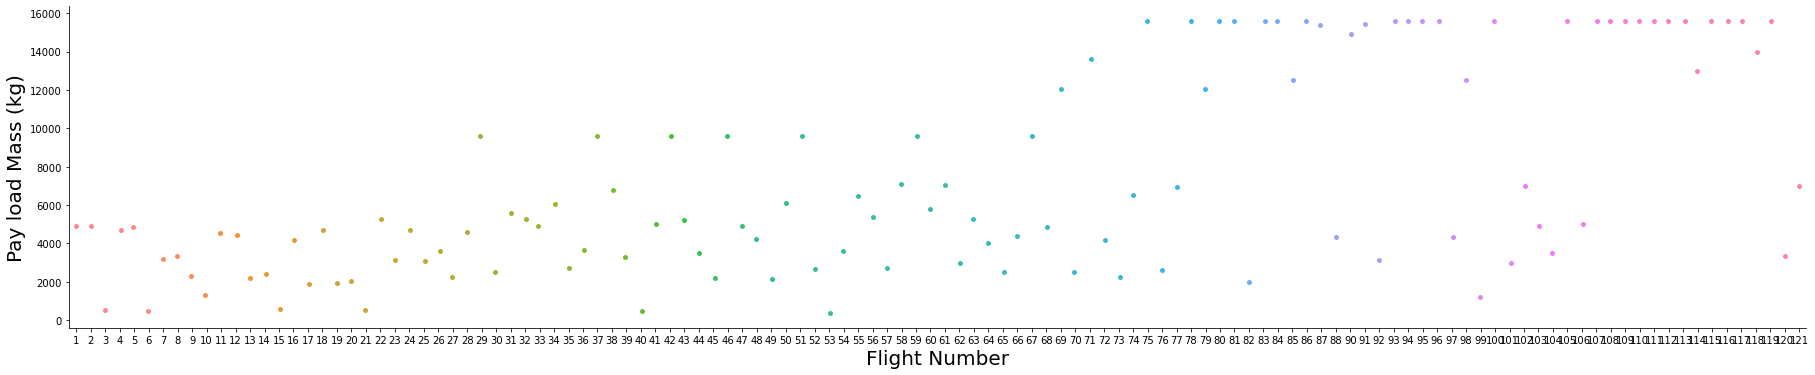

In [23]:
sns.catplot(y="Payload mass", x="Flight No.", data=df2, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

### Visualize the relationship between LaunchSite and Payload Mass with Status

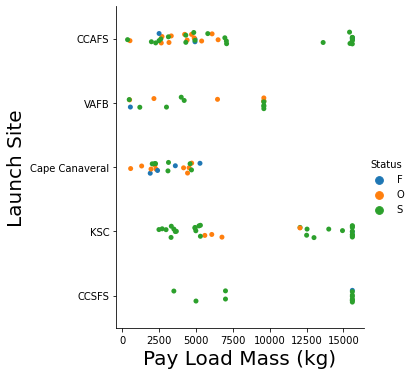

In [24]:
sns.catplot(y="Launch site", x="Payload mass", hue="Status", data=df2)
plt.xlabel("Pay Load Mass (kg)",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

### Visualize the relationship between LaunchSite and FlightNumber with Status

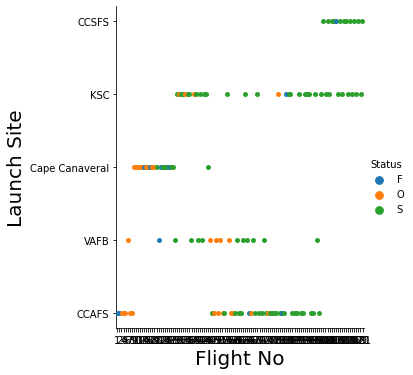

In [25]:
sns.catplot(y="Launch site", x="Flight No.", hue="Status", data=df2)
plt.xlabel("Flight No",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

### Visualize the relationship between success rate of each year

In [26]:
Year = []
for i in range(len(df2['Date'])):
    Year.append(((df2['Date'][i]).split(" "))[-1])


In [27]:
Year = [int(x) for x in Year]
df2['Year'] = Year

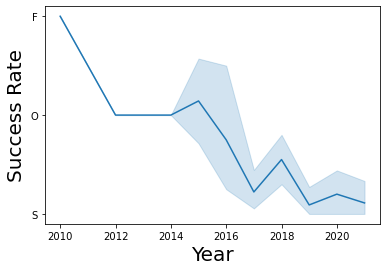

In [28]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
Year = df2['Year']
sns.lineplot(data=df2, x="Year", y="Status")
plt.xlabel("Year",fontsize=20)
plt.ylabel("Success Rate",fontsize=20)
plt.show()


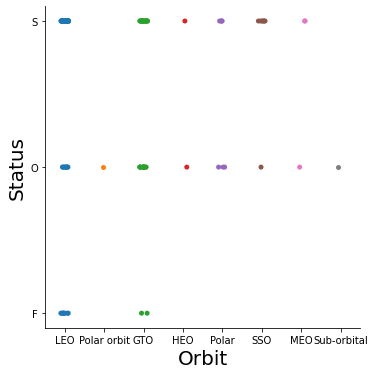

In [29]:
sns.catplot(y="Status", x="Orbit", data=df2)
plt.ylabel("Status",fontsize=20)
plt.xlabel("Orbit",fontsize=20)
plt.show()

# predictive analysis (classification)

In [30]:


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Plot confusion matrix later

In [31]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

As we have manually created a new column named "Status", so we change "O, S, F" to numeric values

In [32]:
Y = []
for i in range(len(df2["Status"])):
    if df2["Status"][i] == 'F':
        Y.append(-1)
    elif df2["Status"][i] == 'O':
        Y.append(0)
    elif df2["Status"][i] == 'S':
        Y.append(1)


In [33]:
Y = np.array(Y)
Y


array([-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,
        0,  0,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  0,  1,  1,  0,
        1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0,  0,  0,  0,
        0,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1, -1,  0,  1,  1,
        1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1, -1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1])

In [34]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
data.head()
Y = data["Class"].to_numpy()

Standardize the data in X then reassign it to the variable X using the transform provided below.

In [35]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X) 
X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

### find best paramters using GridSearch using different models

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

#### Logistic Regression

In [37]:
parameters ={"C":[0.01,0.05, 0.2, 0.5,1],'penalty':['l2'], 'solver':['lbfgs']}
lr=LogisticRegression()

logreg_cv = GridSearchCV(lr, parameters, cv=8)
logreg_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.05, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8727678571428572


#### support vector machine

In [38]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'), 'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(svm, parameters, cv=8)
svm_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}
accuracy : 0.8727678571428572


#### Decision Tree

In [39]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(tree, parameters, cv=8)
tree_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.9196428571428572


C:\Users\HiUser\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


#### KNN Classifier

In [40]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters, cv=8)
knn_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1}
accuracy : 0.8727678571428572


## Model Evaluation

#### Logistic Regression

Logistic Regression
Accuracy: 0.8148148148148148


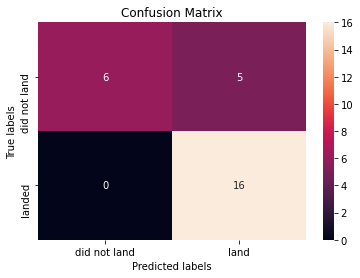

In [41]:
#Accuracy Score and Confusion Matrix
print("Logistic Regression")
print("Accuracy:" ,logreg_cv.score(X_test, Y_test))

yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### support vector machine

support vector machine
Accuracy: 0.7777777777777778


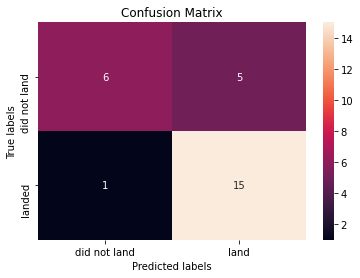

In [42]:
#Accuracy Score and Confusion Matrix
print("support vector machine")
print("Accuracy:" ,svm_cv.score(X_test, Y_test))

yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Decision Tree

Decision Tree
Accuracy: 0.9259259259259259


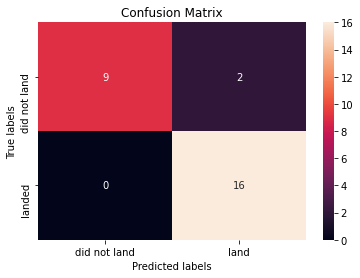

In [43]:
#Accuracy Score and Confusion Matrix
print("Decision Tree")
print("Accuracy:" ,tree_cv.score(X_test, Y_test))

yhat=tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### KNN Classifier

Decision Tree
Accuracy: 0.8148148148148148


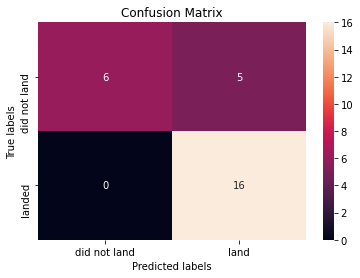

In [44]:
#Accuracy Score and Confusion Matrix
print("Decision Tree")
print("Accuracy:" ,knn_cv.score(X_test, Y_test))

yhat=knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Best Model

In [45]:
predictors = [knn_cv, svm_cv, logreg_cv, tree_cv]
predName = np.array(['KNN','SVM','LOG_REG','DECISION_TREE'])
predScore = []
for predictor in predictors:   
    print(predictor.estimator.__class__.__name__)    
    print(predictor.score(X_test, Y_test))
    predScore.append(predictor.score(X_test, Y_test))

predScore = np.array(predScore)

KNeighborsClassifier
0.8148148148148148
SVC
0.7777777777777778
LogisticRegression
0.8148148148148148
DecisionTreeClassifier
0.9259259259259259


### Classification Accuracy

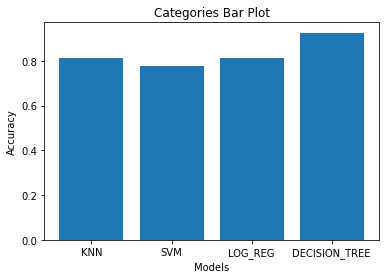

In [46]:
plt.bar(predName,predScore)
plt.xlabel('Models')
plt.ylabel("Accuracy")
plt.title('Categories Bar Plot')
plt.show()
